In [9]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns; sns.set()
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from pandas.util import hash_pandas_object

## Import data

In [10]:
data = pd.read_csv('../data/en.openfoodfacts.org.products.csv', sep = '\t')

/Users/romain/anaconda/envs/ada/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,24,25,26,28,44,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Drop columns not needed and explore missing values

In [11]:
columns2drop = ["creator","code","url","created_t","created_datetime","last_modified_t","last_modified_datetime",
               "brands", "brands_tags","origins", "origins_tags", "manufacturing_places","manufacturing_places_tags",
                "labels_tags","emb_codes","emb_codes_tags","first_packaging_code_geo","cities", "cities_tags", 
                "purchase_places", "stores", "countries","countries_tags", "countries_en","states","states_tags", 
                "states_en","image_url", "image_small_url", "image_ingredients_url","image_ingredients_small_url",
                "image_nutrition_url","image_nutrition_small_url","additives"]

In [12]:
data = data.drop(columns2drop,axis=1)

In [13]:
data = data.replace("unknown",np.nan)

In [14]:
columns2keep = data.columns[data.count()/len(data.index)*100 > 3].values

In [15]:
data = data[columns2keep]

#### We export to a CSV file the completeness of each column along with the most frequent values

In [16]:
nRows = len(data.index)
odf = pd.DataFrame(columns = ["most_frequent_1","most_frequent_2","most_frequent_3","most_frequent_4","most_frequent_5"])

for col in data.columns:
    freq_list = data[col].value_counts().head(5).index.tolist()
    while (len(freq_list) < 5) :
        freq_list.append("")
    odf.loc[col] = freq_list

odf.insert(0,"completeness",(data.count()/len(data.index)*100).values)
odf.head(10)

,completeness,most_frequent_1,most_frequent_2,most_frequent_3,most_frequent_4,most_frequent_5
product_name,95.019717,Comté,Filet de poulet,Emmental,Miel,Aceite de oliva virgen extra
generic_name,8.866342,Pâtes alimentaires au blé dur de qualité supér...,Beignets fourrés à la purée de framboise,Pâtes alimentaires de qualité supérieure,Beignets fourrés à la purée de pomme,Bière
quantity,31.055727,500 g,250 g,200 g,100 g,400 g
packaging,17.836446,"sachet,plastique","Sachet,Plastique",Plastique,Kunststoff,"Bouteille,Verre"
packaging_tags,17.835778,"sachet,plastique",plastique,carton,"bouteille,verre",sachet
categories,37.001845,Boissons,"Viandes, Volailles, Poulets, Filets de poulet","Boissons, Boissons avec sucre ajouté",Matières grasses,"Snacks, Snacks sucrés, Chocolats, Chocolats noirs"
categories_tags,37.001463,"en:plant-based-foods-and-beverages,en:plant-ba...","en:beverages,en:non-alcoholic-beverages,en:uns...","en:snacks,en:sweet-snacks,en:biscuits-and-cake...","en:beverages,en:non-alcoholic-beverages","en:snacks,en:sweet-snacks,en:chocolates,en:dar..."
categories_en,37.001463,"Plant-based foods and beverages,Plant-based fo...","Beverages,Non-Alcoholic beverages,Unsweetened ...","Snacks,Sweet snacks,Biscuits and cakes,Biscuits","Beverages,Non-Alcoholic beverages","Snacks,Sweet snacks,Chocolates,Dark chocolates"
labels,19.676954,en:gluten-free,Bio,en:organic,Point Vert,"Bio, Bio européen, AB Agriculture Biologique ..."
labels_en,19.679245,Organic,Gluten-free,"Organic,EU Organic,fr:ab-agriculture-biologique",Green Dot,"Vegetarian,Vegan"


In [17]:
odf.to_csv('odf.csv')

After visualizing the CSV file, no values among the most frequent ones caracterize missing values.

# FOOD CATEGORIES

In our first step, we aim to categorize products according to their PNNS Category.

https://www.cerin.org/rapports/groupes-groupes-daliments/

In [18]:
initial_data = data.copy()


In [19]:
data = initial_data.copy()

In [20]:
# 8 category from PNNS norm
pnns_category = ["Dairies","Composite","Fish Meat Eggs","Beverages","Fat Sauces","Fruits Vegetables","Starchy","Snacks"]

### From pnns_groups_1 column

In [21]:
initial_data["pnns_groups_1"].value_counts()

Sugary snacks              58626
Milk and dairy products    43945
Fish Meat Eggs             43040
Cereals and potatoes       34562
Beverages                  29319
Fat and sauces             28375
Composite foods            25712
Fruits and vegetables      24710
Salty snacks               19978
sugary-snacks               3498
fruits-and-vegetables       2924
cereals-and-potatoes          44
salty-snacks                   5
Name: pnns_groups_1, dtype: int64

In [22]:
# dictionnary to normalize category names into PNNS category
pnns1_category = {
 'Sugary snacks' : 'Snacks', 
 'Milk and dairy products' : 'Dairies',
 'Composite foods' : 'Composite', 
 'Cereals and potatoes' : 'Starchy', 
 'Fish Meat Eggs' : 'Fish Meat Eggs',
 'Beverages' : 'Beverages',
 'Fat and sauces' : 'Fat Sauces',
 'Fruits and vegetables' : 'Fruits Vegetables',
 'Salty snacks' : 'Snacks',
 'fruits-and-vegetables' : 'Fruits Vegetables',
 'sugary-snacks' : 'Snacks',
 'cereals-and-potatoes' : 'Starchy',
 'salty-snacks' : 'Snacks'
}
data.loc[:,'pnns_groups_1'] = data['pnns_groups_1'].map(pnns1_category)
data = data.rename(columns={"pnns_groups_1": "pnns_category"})

In [23]:
# New pnns categories
data["pnns_category"].value_counts()

Snacks               82107
Dairies              43945
Fish Meat Eggs       43040
Starchy              34606
Beverages            29319
Fat Sauces           28375
Fruits Vegetables    27634
Composite            25712
Name: pnns_category, dtype: int64

### From pnns_groups_2 column

In [24]:
# Values of pnns_groups_2 which haven't been classified in pnns_category
data.loc[data.pnns_category.isna()]["pnns_groups_2"].value_counts()

Alcoholic beverages       10460
Pizza pies and quiches      402
Name: pnns_groups_2, dtype: int64

In [25]:
# dictionnary to extend pnns_categories from pnns_groups_2
pnns2_category = {
 'Pizza pies and quiches' : 'Composite', 
 'Alcoholic beverages' : 'Beverages',
}
data.loc[data.pnns_category.isna(),'pnns_category'] = data.loc[data.pnns_category.isna()]['pnns_groups_2'].map(pnns2_category)
data = data.drop('pnns_groups_2',axis=1)

In [26]:
data["pnns_category"].value_counts()

Snacks               82107
Dairies              43945
Fish Meat Eggs       43040
Beverages            39779
Starchy              34606
Fat Sauces           28375
Fruits Vegetables    27634
Composite            26114
Name: pnns_category, dtype: int64

### From main_category_en column


In [27]:
data.loc[data.pnns_category.isna()]["main_category_en"].value_counts().head(30)

Beverages                          9485
Groceries                          6052
Plant-based foods and beverages    5362
Snacks                             3535
Dietary supplements                2032
Dairies                            1578
Desserts                           1300
Sweeteners                         1248
Baby foods                         1242
Cooking helpers                     743
Crêpes and galettes                 689
Food additives                      595
Non food products                   521
Canned foods                        480
Frozen foods                        452
Spreads                             398
Cocoa and chocolate powders         332
Licensed products                   306
Syrups                              288
Chips and fries                     267
es:bolleria-industrial              237
fr:bloc-de-foie-gras-de-canard      229
Pizza dough                         204
Breakfasts                          198
Banana-crisps                       197


In [28]:
# After inspecting the food type for the 30 most frequent values in main_category_en, we create the following dictionary
maincategoryen_category = {
'Beverages' : 'Beverages',
'Snacks' : 'Snacks',
'Dairies' : 'Dairies',
'Desserts' : 'Dairies',
'Crêpes and galettes' : 'Snacks',
'Cocoa and chocolate powders': 'Snacks',
'Syrups':'Fat Sauces',
'Chips and fries': 'Snacks',
'es:bolleria-industrial': 'Snacks',
'fr:bloc-de-foie-gras-de-canard': 'Fish Meat Eggs' ,
'Pizza dough' : 'Starchy',
'Breakfast' : 'Starchy',
'Banana-crisps' : "Snacks",
'Fish eggs' : 'Fish Meat Eggs',
'Terrines' : 'Fish Meat Eggs',
'fr:escalopes' : 'Fish Meat Eggs',
'Salads' : 'Fruits Vegetables',
'fr:pilons-de-poulet' : 'Fish Meat Eggs'
}

data.loc[data.pnns_category.isna(),'pnns_category'] =  data.loc[data.pnns_category.isna(),'main_category_en'].map(maincategoryen_category)
data = data.drop('main_category_en',axis=1)


In [29]:
sum(data["pnns_category"].value_counts())/len(data)

0.3290845377633065

**After these steps, we managed to categorize 33% of our date among PNNS groups.**

For the unclassified data, the other columns don't bring any strong evidence for the categorization of the product. For instance, a lot of Dietary Supplements or Non Food Products are unclassified. Also, the table beneath shows that below 6% of the unclassified data have values in columns representing categories.

In [30]:
data.loc[data.pnns_category.isnull()].count().sort_values(ascending=False)/len(data.loc[data.pnns_category.isnull()])

product_name                               0.931412
energy_100g                                0.767232
proteins_100g                              0.764975
carbohydrates_100g                         0.763191
fat_100g                                   0.762912
sugars_100g                                0.749857
salt_100g                                  0.745506
sodium_100g                                0.745460
energy-kcal_100g                           0.741572
saturated-fat_100g                         0.730360
ingredients_text                           0.333944
additives_n                                0.333791
ingredients_from_palm_oil_n                0.333791
ingredients_that_may_be_from_palm_oil_n    0.333791
fiber_100g                                 0.253628
serving_quantity                           0.249664
serving_size                               0.249524
nova_group                                 0.193878
additives_en                               0.186772
additives_ta

In [31]:
classified_data = data.loc[~data.pnns_category.isnull()]
unclassified_data = data.loc[data.pnns_category.isnull()]

In [32]:
classified_data.loc[~classified_data.ingredients_text.isnull(),"ingredients_text"].count()/len(classified_data)

0.6275750842649371

33% of the remaining data has a list of ingredients, and 62% of our classified data also has a list of ingredients. We will use Jaccard similarities on the words in ingredient_text to associate unclassified products to categories if the similarity is big enough.

### Using Ingredients_text column (IN THE WORKINGS)

In [59]:
classified_data.loc[:,"ingredients_text"] = classified_data.loc[:,"ingredients_text"].str.lower() \
                                            .replace('%','') \
                                            .replace('-','') \
                                            .replace(':','') \
                                            .replace(',','') \
                                            .replace("  ",'') \
                                            .replace("(",'') \
                                            .replace(")",'') \
                                            .replace(";",'')  


In [62]:
from collections import Counter

stopWords = stopwords.words('french')

classified_data.loc[:,"ingredients_text"] = classified_data.loc[:,"ingredients_text"].str.lower()

def createWordSet(df):
    
    count = Counter([ word for sentence in df.loc[~df["ingredients_text"].isnull(),"ingredients_text"].tolist() for word in sentence.split(" ")])
    return [word[0] for word in count.most_common(100)]

res = classified_data.groupby("pnns_category").apply(createWordSet)

In [ ]:
res["Fat Sauces"]


### PACKAGING

In [16]:
# ebauche of dictionnary to class type of packaging Plastique/Recylable(nonplastik)/nonrecyclable
pack_mapping = dict.fromkeys(['plastic', 'plastique,frais','plastique', 'barquette,plastique', 'sachet,plastique',
                              'frais,plastique','carton,plastique','carton,plastique,surgele','flacon,plastique'
                 'sachet-plastique','carton,boite,plastique', 'boite,plastique', 'plastique,carton','sachet-plastique',
                'sachet,plastique,surgele','barquette,plastique,frais','pot,plastique','plastique,sachet',
                             'plastico','boite,carton,plastique','frais,plastique,carton','frais,carton,plastique',
                              'carton,sachet,plastique','kunststoff','barquette,film,plastique,sous-atmosphere-protectrice',
                             'carton,surgele,plastique','plastique,barquette','sachet,plastique,frais',
                             'barquette,plastique,sous-atmosphere-protectrice','frais,barquette,plastique,opercule,film-plastique,sous-atmosphere-protectrice',
                             'sachet,plastique,carton','film,plastique','sachet,plastique,sous-atmosphere-protectrice',
                             'bolsa-de-plastico,ultracongelado','barquette-plastique','plastique,sous-vide','plastic,bag',
                             'barquette,film,plastique','plastik','plastica','pot-plastique','plastic-bag','boite-plastique',
                             'frais,barquette,plastique','05-pp','pp','sachet,plastique,etui,carton','bolsa-de-plastico',
                             'boite,carton,sachet,plastique','pot,plastique,frais','botella,plastico','sachet,plastique,doypack',
                             'sachet,plastique,sachet','plastique,boite','plastique,surgele','sac-plastique'],'Plastic')

pack_mapping.update(dict.fromkeys(['bouteille,verre','carton','boite,carton','carton,surgele','karton','carton,boite','karton,kunststoff',
                                  'sachet,papier','papier','bouteille,plastique','conserve','bocal,verre','glas',
                                  'bouteille','conserve,metal','bocal,verre,couvercle,metal','bocal,verre,metal',
                                  'verre','verre,bouteille','pot,verre','bocal','verre,bocal',
                                  'flacon,plastique','bouteille-plastique','bottle','canned','pot-en-verre','bolsa,plastico',
                                   'bouteille-verre','bocal-en-verre','verre,bocal,metal','plastique,bouteille','bouteille-en-verre','canette','pot,verre,couvercle,metal',
                                  'glas,mehrwegpfand','carton,aluminium','boite,metal','botella-de-plastico','boite-carton',
                                  'plastic-bottle','sous-vide','plastic,bottle','can','pot-en-plastique','glass','caja,carton','bote-de-vidrio',
                                  'boite,conserve,metal','pet','becher','lata','bocal-verre','aluminium','caja-de-carton','bouteille,verre,capsule,metal',
                                  'bokaal,glas','konserve','paper','glass-bottle','bocal,verre,couvercle,metal,conserve','glass-jar',
                                  'glasflasche','flacon-verre','glas,flasche','kunststoff,karton','papier,aluminium','boite-de-conserve',
                                  'pot-verre','canette,metal','carton,brique','flacon,verre','caja,carton,lata,en-conserva','bocal-verre,couvercle-metal','glass,bottle',
                                  'conserve,boite,metal','carton,sachet','canette,aluminium','brique,carton','boite-en-carton','conserve,conserve'],'Recyclable'))

pack_mapping.update(dict.fromkeys(['frais','surgele','surgele,carton,plastique','tetra-pak','tetra-brik','tetrapak',
                                  'brique','tetrapack','surgele,carton','barquette,film,plastique,frais,sous-atmosphere-protectrice','sous-atmosphere-protectrice',
                                  'carton,plastique,frais','frais,pot,plastique'],'Non-Recyclable'))


data['emballage'] = data['packaging_tags'].replace(pack_mapping)

# NUTRISCORE
https://quoidansmonassiette.fr/comment-est-calcule-le-nutri-score-logo-nutritionnel/



#### Import just enough field

In [17]:
# replace NàN of 'fruits-vegetables-nuts_100g' by 100 if it is 'Fruit juices'
data[(data['main_category_en'] == 'Fruit juices')]['fruits-vegetables-nuts_100g'].fillna(100, inplace=True)

/Users/Matt/anaconda3/envs/ada/lib/python3.7/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [18]:
selected_enough_field =[
    'Category_Food',
    'energy_100g','sugars_100g','saturated-fat_100g','sodium_100g',
    'fruits-vegetables-nuts_100g','fiber_100g','proteins_100g',
    'nutrition-score-uk_100g','nutrition_grade_fr'
]

In [19]:
# divide dataframe into 3 groups to simplify the calculation of nutriscrore
data_beverages = data[data['Category_Food']=='Beverages'][selected_enough_field]
data_fatsauces = data[data['Category_Food']=='Fat Sauces'][selected_enough_field]
data_without_beverage_fat = data[(data['Category_Food']!='Fat Sauces') & (data['Category_Food']!='Beverages') ][selected_enough_field]
                                    
                                    

### Calculation of negative points

In [20]:
## ENERGY
# energy bins
energy_bins_without_beverage_fat = [data_without_beverage_fat['energy_100g'].min() - 1, 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350, data_without_beverage_fat['energy_100g'].max()]
energy_bins_fatsauces = [data_fatsauces['energy_100g'].min() - 1, 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350, data_fatsauces['energy_100g'].max()]
energy_bins_beverages = [data_beverages['energy_100g'].min() - 1, 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, data_beverages['energy_100g'].max()]
# energy point
data_without_beverage_fat['energy_points'] = pd.cut(data_without_beverage_fat['energy_100g'], energy_bins_without_beverage_fat, labels=range(11)).astype(float)
data_fatsauces['energy_points'] = pd.cut(data_fatsauces['energy_100g'], energy_bins_fatsauces, labels=range(11)).astype(float)
data_beverages['energy_points'] = pd.cut(data_beverages['energy_100g'], energy_bins_beverages, labels=range(11)).astype(float)


## SUGAR
# sugar bins
sugar_bins_without_beverage_fat = [data_without_beverage_fat['sugars_100g'].min() - 1, 0, 1.5, 3, 4.5, 6, 7.5, 9, 10.5, 12, 13.5, data_without_beverage_fat['sugars_100g'].max()]
sugar_bins_fatsauces = [data_fatsauces['sugars_100g'].min() - 1, 0, 1.5, 3, 4.5, 6, 7.5, 9, 10.5, 12, 13.5, data_fatsauces['sugars_100g'].max()]
sugar_bins_beverages = [data_beverages['sugars_100g'].min() - 1, 4.5, 9, 13.5, 18, 22.5, 27, 31, 36, 40, 45, data_beverages['sugars_100g'].max()]
# sugar point (CHANGE SUGAR_BINS)
data_without_beverage_fat['sugar_points'] = pd.cut(data_without_beverage_fat['sugars_100g'], sugar_bins_without_beverage_fat, labels=range(11)).astype(float)
data_fatsauces['sugar_points'] = pd.cut(data_fatsauces['sugars_100g'], sugar_bins_fatsauces, labels=range(11)).astype(float)
data_beverages['sugar_points'] = pd.cut(data_beverages['sugars_100g'], sugar_bins_beverages, labels=range(11)).astype(float)


## SATURATED FAT
# s-fat bins
fat_bins_without_beverage_fat = [data_without_beverage_fat['saturated-fat_100g'].min() - 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, data_without_beverage_fat['saturated-fat_100g'].max()]
fat_bins_beverages = [data_beverages['saturated-fat_100g'].min() - 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, data_beverages['saturated-fat_100g'].max()]
fat_bins_fatsauces = [data_fatsauces['saturated-fat_100g'].min() - 1, 10, 16, 22, 28, 34, 40, 46, 52, 58, 64, data_fatsauces['saturated-fat_100g'].max()]
# s-FAT point (CHANGE FAT_BINS)
data_without_beverage_fat['saturated-fat_points'] = pd.cut(data_without_beverage_fat['saturated-fat_100g'], fat_bins_without_beverage_fat, labels=range(11)).astype(float)
data_beverages['saturated-fat_points'] = pd.cut(data_beverages['saturated-fat_100g'], fat_bins_beverages, labels=range(11)).astype(float)
data_fatsauces['saturated-fat_points'] = pd.cut(data_fatsauces['saturated-fat_100g'], fat_bins_fatsauces, labels=range(11)).astype(float)


## SODIUM
# sodium bins
sodium_bins = [data['sodium_100g'].min() - 1, 90, 180, 270, 360, 450, 540, 630, 720, 810, 900, data['sodium_100g'].max()]
# sodium points
data_without_beverage_fat['sodium_points'] = pd.cut(data_without_beverage_fat['sodium_100g'], sodium_bins, labels=range(11)).astype(float)
data_beverages['sodium_points'] = pd.cut(data_beverages['sodium_100g'], sodium_bins, labels=range(11)).astype(float)
data_fatsauces['sodium_points'] = pd.cut(data_fatsauces['sodium_100g'], sodium_bins, labels=range(11)).astype(float)



### Calculation positive points

In [21]:
# FRUITS
# fruits bins
fruits_bins_without_beverage_fat = [data_without_beverage_fat['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data_without_beverage_fat['fruits-vegetables-nuts_100g'].max()]
fruits_bins_fatsauces = [data_fatsauces['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data_fatsauces['fruits-vegetables-nuts_100g'].max()]
fruits_bins_beverages = [data_beverages['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data_beverages['fruits-vegetables-nuts_100g'].max()]
# fruits points
data_without_beverage_fat['fruits_points'] = pd.cut(data_without_beverage_fat['fruits-vegetables-nuts_100g'], fruits_bins_without_beverage_fat, labels=[0,1,2,5]).astype(float)
data_beverages['fruits_points'] = pd.cut(data_beverages['fruits-vegetables-nuts_100g'], fruits_bins_beverages, labels=[0,2,4,10]).astype(float)
data_fatsauces['fruits_points'] = pd.cut(data_fatsauces['fruits-vegetables-nuts_100g'], fruits_bins_fatsauces, labels=[0,1,2,5]).astype(float)


# FIBRES
# fibers bins
fibers_bins = [data['fiber_100g'].min() - 1, 0.7, 1.4, 2.1, 2.8, 3.5, data['fiber_100g'].max()]
# fibers points
data_without_beverage_fat['fiber_points'] = pd.cut(data_without_beverage_fat['fiber_100g'], fibers_bins, labels=range(6)).astype(float)
data_beverages['fiber_points'] = pd.cut(data_beverages['fiber_100g'], fibers_bins, labels=range(6)).astype(float)
data_fatsauces['fiber_points'] = pd.cut(data_fatsauces['fiber_100g'], fibers_bins, labels=range(6)).astype(float)

# PROTEINS
# proteins bins
proteins_bins = [data['proteins_100g'].min() - 1, 1.6, 3.2, 4.8, 6.4, 8.0, data['proteins_100g'].max()]
# proteins points
data_without_beverage_fat['proteins_points'] = pd.cut(data_without_beverage_fat['proteins_100g'], proteins_bins, labels=range(6)).astype(float)
data_beverages['proteins_points'] = pd.cut(data_beverages['proteins_100g'], proteins_bins, labels=range(6)).astype(float)
data_fatsauces['proteins_points'] = pd.cut(data_fatsauces['proteins_100g'], proteins_bins, labels=range(6)).astype(float)


In [22]:
# rejoin last separated dataframe
frames = [data_without_beverage_fat, data_beverages, data_fatsauces]
nutridata = pd.concat(frames)

In [23]:
# concession made to put 0 inplace of Nan of 'fruits_points','fiber_points','proteins_points' 
# this will not be a problem we do not substract Positive point
nutridata['fruits_points'].fillna(0, inplace=True)
nutridata['fiber_points'].fillna(0, inplace=True)
nutridata['proteins_points'].fillna(0, inplace=True)

In [24]:
#calculation of P x N
nutridata['points_N']= nutridata['energy_points'] + nutridata['saturated-fat_points'] + nutridata['sugar_points'] + nutridata['sodium_points']
nutridata['points_P'] = nutridata['fruits_points'] + nutridata['fiber_points'] + nutridata['proteins_points']

In [25]:
def compute_score(row):
    N = row['points_N']
    P = row['points_P']
    fruit = row['fruits_points']
    fiber = row['fiber_points']
    if N < 11 or fruit == 5:
        return N - P
    else:
        return N - (fiber + fruit)

In [26]:
nutridata['nutri-score_calculated'] = nutridata.apply(compute_score, axis=1)

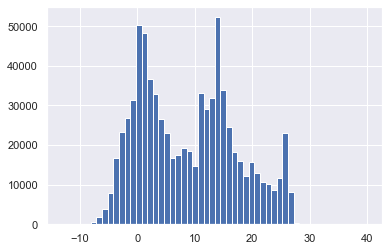

In [27]:
#petite visualization
nutridata['nutri-score_calculated'].hist(bins=int(nutridata['nutri-score_calculated'].max() - nutridata['nutri-score_calculated'].min() + 1));

In [28]:
# re divided dataframe to allow a simpler transformation of score into letter
nutridata_beverages = nutridata[nutridata['Category_Food']=='Beverages']
nutridata_not_beverages = nutridata[nutridata['Category_Food']!='Beverages']

In [29]:
# NUTRILETTER

#letter bins
letter_bins_aliments = [nutridata['nutri-score_calculated'].min() - 1, 0, 2.9, 10.9, 18.9, nutridata['nutri-score_calculated'].max()]
letter_bins_beverages = [nutridata['nutri-score_calculated'].min() - 1, 2.5, 5.5, 9.5, nutridata['nutri-score_calculated'].max()]

#letter
nutridata_not_beverages['nutri-score_letter_CALCULATED'] = pd.cut(nutridata_not_beverages['nutri-score_calculated'], letter_bins_aliments, labels=['a','b','c','d','e'])
nutridata_beverages['nutri-score_letter_CALCULATED'] = pd.cut(nutridata_beverages['nutri-score_calculated'], letter_bins_beverages, labels=['b','c','d','e'])


/Users/Matt/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Matt/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [30]:
nutriframes = [nutridata_not_beverages, nutridata_beverages]
nutridata = pd.concat(nutriframes)

In [31]:
nutridata['nutri-score_letter_CALCULATED'].value_counts()

d    247561
a    160302
c    156517
e    118151
b     87801
Name: nutri-score_letter_CALCULATED, dtype: int64